Bailey Griswold, bg1672  
# Compiling dataframe of alpha and covariance features
1. Feature Engineering
2. Feature Selection Based on Random Forest and LASSO


- Produce two dictionaries: alpha and covariance
- each dictionary holds a dataframe of features for each year from 2010-2016
- each dataframe has all the features that are most strongly correlated with the output variable: ZHVI (or median home values)
- each set of features comes from the following datasets:
a. ZHVI   
b. geography (lat, long, area)  
c. med listing price  
d. demographic  
e. soc  
f. econ  
g. housing  
h. migration   
i. tax89  
j. tax10  
k. voting  
l. crime  
m. cnty_mrkts

- covar_dict contains all features with high correlation with home values within the same period
- alpha-dict contains all features with high correlation with home values from the next period
- all datasets for each year were merged on FIPS

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as pl
import datetime
import pickle
from bqplot import pyplot as plt
from bqplot import *
import seaborn as sns

from math import ceil

from geopandas import GeoDataFrame
from fancyimpute import KNN
import shapely
from fiona.crs import from_epsg

from scipy import stats

import statsmodels.formula.api as smf  

from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.linear_model import RandomizedLasso

### 1. Defining Functions

In [2]:
def column_filter(df,phrase):
    '''produces a list of columns that contain the phrase'''
    start_len = len(df.columns)
    keep_cols = []
    for i in df.columns:
        if phrase in i:
            keep_cols.append(i)
    print ('Columns matching filter: {}'.format(len(keep_cols)))
    return (keep_cols)

In [3]:
def drop_columns(df,phrase,dropped_cols=False):
    '''Drop all columns in dataframe df that contain substring phrase'''
    start_len = len(df.columns)
    drop_cols = []
    for i in df.columns:
        if phrase in i:
            drop_cols.append(i)
            df.drop([i], axis=1, inplace=True)
    print ('Total Columns Dropped: {}'.format(len(drop_cols)))
    if dropped_cols == True:
        print ('Dropped Columns: {}'.format(drop_cols))

#could add inplace feature
#could add upper/lower case feature
    

In [4]:
def feat_sel(df, output, features, model='rf', alpha=100, feat_num=20):
    '''
    performs random forest or lasso fit on specified dataframe and produces a list of 
    the top specified number of features and returns a sorted list of the features and their scores.
    '''
    regressors = features
    #regressors = list(set(df.columns) - set([output]))

    y = df[output]
    X = df[regressors] #select all the columns after id and geography -- the regressors
    names = X.columns

    rlasso = RandomizedLasso(alpha=alpha,random_state=0, normalize=True, fit_intercept=True)
    rlasso.fit(X, y)

    rf = RandomForestRegressor(random_state=0,n_estimators=10)
    rf.fit(X, y)

    if model == 'lasso':
        feat_sort = (sorted(zip(map(lambda x: round(x, 10), rlasso.scores_), names), reverse=True))
    else: 
        feat_sort = (sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True))
        print ('R-Score', rf.score(X, y))

    pl.figure(figsize=(8,6))
    pl.title("{} Feature importance".format(model))
    pl.bar(np.arange(feat_num), pd.DataFrame(feat_sort)[0][:feat_num], align='center')
    pl.xticks(np.arange(feat_num))
    pl.ylabel('Importance Score')

    print("{} Feature ranking:".format(model), pd.DataFrame(feat_sort)[:5])
    return feat_sort

In [5]:
def mdl_eval(mdl, output, regressors, test, train, color):
    ''' For a specific model, produce the in sample R square value, the out of sample r sqaure, 
        and the median absolute error. Returns the '''
    
    print ('In Sample RSquared: ', mdl.score(train[regressors], train[output]))
    Rout = r2_score(test[output], mdl.predict(test[regressors]))
    R = Rout
    p = len(regressors)
    n = len(test)
    Radj = R - ((1 - R)*((p)/(n-p-1)))
    print ('Out of sample R-Squared: ', Rout)
    print ('Out of sample Adjusted R-Squared: ', Radj)
    model_score = median_absolute_error(test[output], mdl.predict(test[regressors]))
    print ('Model Eval (Median Absolute Error): ', model_score)
    
    pl.figure(figsize=(8,6))
    pl.title("Radj = {}, p = {}".format(Radj, p), fontsize=16)
    pl.plot(test[output], mdl.predict(test[regressors]), 'o', alpha=.5, c=color)
    pl.plot(test[output], test[output])
    pl.xlabel('Observed Values', fontsize=14)
    pl.ylabel('Predicted Values', fontsize=14)
    
    return (Radj, model_score)

In [6]:
def merge_check(df1, df2, on1, on2):
    '''Input two dataframes to be merged. Returns the percent of 
    each dataframe that would be preserved on an inner merge. Also
    returns merged dataframe.'''
    df1_size = len(df1)
    df2_size = len(df2)
    merged_df = pd.merge(df1, df2, left_on=on1, right_on=on2, how='inner')
    inmerge_size = len(merged_df)
    print ('df1 = {}%'.format((inmerge_size/df1_size)*100))
    print ('df2 = {}%'.format((inmerge_size/df2_size)*100))
    return merged_df

In [7]:
def abs_perc(df, yr):
    try:
        df = pd.merge(df, census['dem'][yr][['FIPS','Percent__SEX_AND_AGE__Total_population']], 
                                          on='FIPS', how='left')
    except KeyError:
        df = pd.merge(df, census['dem'][2010][['FIPS','Percent__SEX_AND_AGE__Total_population']], 
                                          on='FIPS', how='left')

    for i in df.columns:
        new_col = str(i+'percent')
        try: 
            df[new_col] = (df[i] / df['Percent__SEX_AND_AGE__Total_population'])*100
        except TypeError:
            pass
        
    df.drop(['Percent__SEX_AND_AGE__Total_population', 'Percent__SEX_AND_AGE__Total_populationpercent'], axis=1, inplace=True)

    return df

In [8]:
def log_tform_cols(df):
    '''For every column in the dataframe that has numeric values, 
    take the log transform of it and create a new column.'''
    df.replace(to_replace=0, value=1, inplace=True)
    for i in df.columns:
        try:
            df[i+'_log'] = np.log(df[i])
        except AttributeError:
            pass
    return df

In [9]:
def feature_selection(yname,df,featuers_selvalue,rows,cols,threshold=0.5):
    '''
    df: dataframe containing all features and y (may contain unused ones)
    featuers_selvalue: feature names to use in this selection
    threshold: correlation threshold for screening. Function written by Kaili Li.
    '''

    
    feature_list = []
    corr_dict = {}
    
    fig, axes = pl.subplots(rows,cols, figsize = (16,rows*2.5))
    for idx in range(len(featuers_selvalue)):

        left = int(idx/cols)
        right = idx - int(idx/cols)*cols
        data = df[[yname]+ featuers_selvalue]
        axes[left, right].scatter(data.iloc[:,idx],data.iloc[:,0],alpha=0.5)

        #data = data.dropna()
        #corr = np.corrcoef(data.T)[0,1]
        #corr_dict[featuers_selvalue[idx]] = corr

        #if (abs(corr)>=threshold):
        #    feature_list.append(featuers_selvalue[idx])

        #axes[left,right].set_title('corr: '+str(round(corr,3)))
        #axes[left,right].set_xlabel(featuers_selvalue)
        axes[left,right].set_ylabel(yname)

        pl.tight_layout()

    pl.show()
    
    return feature_list,corr_dict

In [10]:
covar_dict = {}
alpha_dict = {}

In [11]:
#making a list of potential output variables
home_value_indicators = ['Med_Listing_Price_Sfr','ZHVI_SingleFamilyResidence',
                         'Med_Listing_Price_AllHomes', 
                         'ZHVI_AllHomes', 'County_MedianValuePerSqft_AllHomes']

In [12]:
zillow_feats = [word+'_next' for word in home_value_indicators] + [word+'_current' for word in home_value_indicators]

## 2)  Loading Data
a. Zillow Data   
b. Census Data (housing, economic, social, demographic, and migration)  
c. geography (lat, long, area)    
d. tax data   
e. voting  
f. crime  

### a. Zillow Data
(data from Zillow)

In [13]:
path = './data/dataframes/z_yrly.csv'
zil = pd.read_csv(path)
zil.drop(['Unnamed: 0'], axis=1, inplace=True)
zil.FIPS = zil.FIPS.apply(str)
zil.FIPS = zil.FIPS.str.zfill(5)
zil.head(2)

,FIPS,RegionName,State,feature,1996,1997,1998,1999,2000,2001,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,06037,Los Angeles,CA,ZHVI_1bedroom,93422.222222,94383.333333,105166.666667,113266.666667,127108.333333,144191.666667,...,324808.333333,272375.0,260958.333333,242525.000000,234208.333333,284983.333333,319741.666667,345475.000000,378241.666667,405955.555556
1,17031,Cook,IL,ZHVI_1bedroom,89411.111111,92375.000000,99258.333333,110450.000000,129041.666667,148541.666667,...,195833.333333,174325.0,160983.333333,141366.666667,130341.666667,140666.666667,152991.666667,156933.333333,164616.666667,171544.444444


In [14]:
zillow = {}
for yr in zil.columns[4:]:
    zillow[yr] = zil.pivot(index='FIPS', columns='feature', values=yr)#.reset_index()
    zillow[yr].drop_duplicates(inplace=True)
    zillow[yr].dropna(how='all', inplace=True)
    zillow[yr].dropna(axis=1, how='all', inplace=True)
    try: 
        zillow[yr].drop(['ZHVI_BottomTier_yoy'], axis=1,  inplace=True)
    except ValueError:
        pass
    try: 
        zillow[yr].drop(['ZHVI_MiddleTier_yoy'], axis=1,  inplace=True)
    except ValueError:
        pass
    try: 
        zillow[yr].drop(['ZHVI_TopTier_yoy'], axis=1,  inplace=True)
    except ValueError:
        pass
    zillow[yr].drop(['ZHVI_2bedroom',
       'ZHVI_3bedroom', 'ZHVI_4bedroom', 'ZHVI_5BedroomOrMore',
       'ZHVI_BottomTier', 'ZHVI_Condominum','ZHVI_1bedroom',
        'ZHVI_TopTier', 'ZHVI_MiddleTier'], axis=1,  inplace=True)
    zillow[yr] = zillow[yr].reset_index()
    
    
#dropping these fields because they are redundant for home prices

In [15]:
mrkt = {}
for yr in np.arange(1996, 2018):
    mrkt[yr] = zillow[str(yr)]

In [16]:
mrkt[2016]['FIPS'] = mrkt[2016]['FIPS'].str.strip('0')
map_fig = plt.figure(title='Med Listing Price by County', min_width=1300, min_height=800)
map_tt = Tooltip(fields=['name', 'color'], labels=['COUNTY'])
map_res = plt.geo(map_data=topo_load('map_data/USCountiesMap.json'), stroke_color='black',
                 colors={'default_color': 'Black'},
                  scales={'projection': AlbersUSA(),
                         'color': ColorScale(scheme='RdYlBu')},
                  color=dict(zip(mrkt[2016]['FIPS'], mrkt[2016]['Med_Listing_Price_AllHomes'])), tooltip=map_tt)
mrkt[2016]['FIPS'] = mrkt[2016]['FIPS'].str.zfill(5)
map_fig

A Jupyter Widget

In [17]:
mrkt[2016]['FIPS'] = mrkt[2016]['FIPS'].str.strip('0')
map_fig = plt.figure(title='ZHVI by County', min_width=1300, min_height=800)
map_tt = Tooltip(fields=['name', 'color'], labels=['COUNTY'])
map_res = plt.geo(map_data=topo_load('map_data/USCountiesMap.json'), stroke_color='black',
                 colors={'default_color': 'Black'},
                  scales={'projection': AlbersUSA(),
                         'color': ColorScale(scheme='RdYlBu')},
                  color=dict(zip(mrkt[2016]['FIPS'], mrkt[2016]['ZHVI_AllHomes'])), tooltip=map_tt)
mrkt[2016]['FIPS'] = mrkt[2016]['FIPS'].str.zfill(5)
map_fig

A Jupyter Widget

Median Listing Price covers more counties but there aren't values for it in early years, while there are values for ZHVI.  Going to use ZHVI as the output, and fillin missing counites with Median Listing Price.

### b. Census Data

In [82]:
pkl_file = open('./data/dataframes/CensusData.pkl', 'rb')
census = pickle.load(pkl_file)
pkl_file.close()

In [83]:
for k in census.keys():
    print (k)
    for yr in census[k].keys():
        census[k][yr]['FIPS'] =  census[k][yr].FIPS.apply(int)
        census[k][yr]['FIPS'] =  census[k][yr].FIPS.apply(str)
        census[k][yr]['FIPS'] = census[k][yr].FIPS.str.zfill(5)

econ
soc
migr
dem
hous


### c. Geography

In [84]:
shape_path="./data/cb_2016_us_county_500k/cb_2016_us_county_500k.shp"
ct_shape = GeoDataFrame.from_file(shape_path)

#pull out lat and long from geometry 
ct_shape['long'] = ct_shape.geometry.centroid.x
ct_shape['lat'] = ct_shape.geometry.centroid.y

#create properly formatted FIPS codes
ct_shape['FIPS'] =ct_shape.STATEFP + ct_shape.COUNTYFP


ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
ct_shape['area'] = ct_shape.to_crs(epsg=2263).geometry.area/(2.788*10**7) #area in mi^2

ct_shape.drop(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'AFFGEOID', 'GEOID', 'NAME', 'LSAD',
       'ALAND', 'AWATER', 'geometry'], axis=1, inplace=True)
ct_shape.head(3)

,long,lat,FIPS,area
0,-92.178640,41.336455,19107,579.930853
1,-93.734124,43.377519,19189,402.084843
2,-101.319890,38.000252,20093,872.855670


### d. Tax

In [85]:
path = './data/tax/County_Tax_2010-2015.csv'
tax10 = pd.read_csv(path,  encoding = "ISO-8859-1")
tax10['FIPS'] = tax10['FIPS'].apply(str)
tax10['FIPS'] = tax10['FIPS'].str.zfill(5)
tax10.head(3)

,STATE,YEAR,FIPS,A00100,A00101,A00200,A00300,A00600,A00650,A00700,...,NUMDEP,PREP,RAC,RAL,SCHF,STATEFIPS,TCE,TOTAL_VITA,VITA,VITA_EIC
0,AL,2010,01000,97604671.0,NaN,72276379.0,1508016.0,1438543.0,1103934.0,NaN,...,1388578.0,1273772.0,NaN,NaN,49990.0,1,NaN,NaN,NaN,NaN
1,AL,2010,01001,1141741.0,NaN,898499.0,10302.0,6121.0,4010.0,NaN,...,17506.0,11995.0,NaN,NaN,419.0,1,NaN,NaN,NaN,NaN
2,AL,2010,01003,4331432.0,NaN,2944594.0,76050.0,85725.0,61562.0,NaN,...,52276.0,47626.0,NaN,NaN,1196.0,1,NaN,NaN,NaN,NaN


In [86]:
for i in list(tax10.columns)[3:]:
    amnt = 'A' + i[-5:]
    nmbr = 'N' + i[-5:]
    try: 
        tax10[i[-5:]] = tax10[amnt] / tax10[nmbr]
    except KeyError:
        pass

In [87]:
path = './data/tax/County_Tax_1989-2009.csv'
tax89 = pd.read_csv(path)
tax89.head()

/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (6,7,8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,STATE,YEAR,FIPS,STATEFIPS,COUNTYFIPS,COUNTY,Number_of_returns,Number_of_exemptions,Adjusted_gross_income,Wages_and_salaries,Dividends_before_exclusion,Interest_received
0,AL,1989,1000,1,0,ALABAMA,1595185.0,3557069.0,39454560.0,31125750.0,638076.0,2392059.0
1,AL,1989,1001,1,1,Autauga,13674.0,31869.0,333060.0,279230.0,3115.0,13269.0
2,AL,1989,1003,1,3,Baldwin,39202.0,86819.0,957370.0,673040.0,24108.0,82778.0
3,AL,1989,1005,1,5,Barbour,9367.0,21385.0,193510.0,153190.0,2729.0,12946.0
4,AL,1989,1007,1,7,Bibb,6347.0,15087.0,129680.0,107400.0,924.0,5794.0


In [88]:
tax89.iloc[:, 6:] = tax89.iloc[:, 6:].apply(pd.to_numeric, errors='coerce')

In [89]:
tax89['FIPS'] = tax89['FIPS'].apply(str)
tax89['FIPS'] = tax89['FIPS'].str.zfill(5)

In [90]:
for i in tax89.columns[7:]:
        tax89[i+'_per_return'] = (tax89[i] / tax89.Number_of_returns)

In [91]:
taxes = {}
for yr in tax10.YEAR.value_counts().index:
    taxes[yr] = tax10[tax10.YEAR == yr]
for yr in tax89.YEAR.value_counts().index:
    taxes[yr] = tax89[tax89.YEAR == yr]

In [137]:
taxes[2005]['FIPS'] = taxes[2005]['FIPS'].str.strip('0')

map_fig = pl.figure(title='AGI by County', min_width=1300, min_height=800)
map_tt = Tooltip(fields=['name', 'color'], labels=['COUNTY'])
map_res = pl.geo(map_data=topo_load('map_data/USCountiesMap.json'), stroke_color='black',
                 colors={'default_color': 'Black'},
                  scales={'projection': AlbersUSA(),
                         'color': ColorScale(scheme='RdYlBu')},
                  color=dict(zip(taxes[2005]['FIPS'], taxes[2005]['Adjusted_gross_income_per_return'])), tooltip=map_tt)
map_fig

/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


A Jupyter Widget

In [30]:
taxes[2005]['FIPS'] = taxes[2005]['FIPS'].str.zfill(5)

/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### e. Voting

In [92]:
path = './data/dataframes/voting.csv'
vot = pd.read_csv(path)

vot.drop(['Unnamed: 0'], axis = 1, inplace=True)
vot.FIPS = vot.FIPS.apply(str)
vot.FIPS = vot.FIPS.str.zfill(4)

vot.head(3)

,State,RegionName,FIPS,feature,2000,2004,2008,2012,2016
0,AL,Autauga,1001,TotalVotes,17208.00,20081.0,23489.0,23856.000,24556.000
1,AL,Autauga,1001,Rpct,69.69,75.7,74.0,0.726,0.734
2,AL,Autauga,1001,Dpct,28.72,23.7,26.0,0.266,0.240


In [93]:
for yr in  [2000, 2004, 2008, 2012, 2016]:
    vot[str(yr+1)] = vot[str(yr)]
    vot[str(yr+2)] = vot[str(yr)]
    vot[str(yr+3)] = vot[str(yr)]

In [94]:
vot.iloc[:, 4:] = vot.iloc[:, 4:].fillna(method='ffill', axis=1)

In [95]:
voting = {}
for yr in np.arange(2000, 2017):
    voting[yr] = vot.pivot(index='FIPS', columns='feature', values=str(yr)).reset_index()

In [35]:
voting[2005]['FIPS'] = voting[2005]['FIPS'].str.strip('0')

map_fig = pl.figure(title='% Democratic Votes by County', min_width=1300, min_height=800)
map_tt = Tooltip(fields=['name', 'color'], labels=['COUNTY'])
map_res = pl.geo(map_data=topo_load('map_data/USCountiesMap.json'), stroke_color='black',
                 colors={'default_color': 'Black'},
                  scales={'projection': AlbersUSA(),
                         'color': ColorScale(scheme='RdYlBu')},
                  color=dict(zip(voting[2005]['FIPS'], voting[2005]['Dpct'])), tooltip=map_tt)
voting[2005]['FIPS'] = voting[2005]['FIPS'].str.zfill(5)

map_fig

A Jupyter Widget

### f. Crime

In [96]:
path = './data/dataframes/df_crime.csv'
crime = pd.read_csv(path)

crime.drop(['Unnamed: 0'], axis = 1, inplace=True)
crime.FIPS = crime.FIPS.apply(str)
crime.FIPS = crime.FIPS.str.zfill(5)

crime.head(3)

,FIPS,RegionName,State,feature,1985,1986,1987,1988,1989,1990,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,01001,Autauga County,AL,Property_crime,2927.4,3940.9,3562.0,4257.1,5078.4,5396.4,...,4611.8,4344.4,4072.1,3930.1,2512.1,3816.3,3777.5,3814.6,3652.5,3585.7
1,01001,Autauga County,AL,Total_crime,3304.3,4765.3,4149.4,5136.1,5850.6,6611.5,...,4926.2,4753.4,4353.8,4216.3,3047.0,4081.3,3953.3,3988.4,3897.1,3813.7
2,01001,Autauga County,AL,Violent_crime,376.9,824.4,587.4,879.0,772.2,1215.1,...,314.4,409.0,281.7,286.2,534.9,265.0,175.8,173.8,244.6,228.0


In [97]:
crime.columns[4:]

Index(['1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993',
       '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002',
       '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011',
       '2012', '2013', '2014'],
      dtype='object')

In [98]:
crime_dict = {}
for yr in crime.columns[4:]:
    crime_dict[int(yr)] = crime.pivot(index='FIPS', columns='feature', values=yr).reset_index()


In [39]:
crime_dict[2005]['FIPS'] = crime_dict[2005]['FIPS'].str.strip('0')

map_fig = pl.figure(title='Property Crime by County', min_width=1300, min_height=800)
map_tt = Tooltip(fields=['name', 'color'], labels=['COUNTY'])
map_res = pl.geo(map_data=topo_load('map_data/USCountiesMap.json'), stroke_color='black',
                 colors={'default_color': 'Black'},
                  scales={'projection': AlbersUSA(),
                         'color': ColorScale(scheme='RdYlBu')},
                  color=dict(zip(crime_dict[2005]['FIPS'], crime_dict[2005]['Property_crime'])), tooltip=map_tt)
crime_dict[2005]['FIPS'] = crime_dict[2005]['FIPS'].str.zfill(5)

map_fig

A Jupyter Widget

## 3. Feature Engineering
- normalizing abosolute values
- taking the log transform
- calculating growth from year to year

** *Normalize Absolutes * **

In [99]:
for yr in crime_dict.keys():
    crime_dict[yr] = abs_perc(crime_dict[yr], yr)

In [100]:
for yr in census['migr'].keys():
    census['migr'][yr] = abs_perc(census['migr'][yr], yr)

In [101]:
for yr in voting.keys():
    voting[yr]= abs_perc(voting[yr], yr)

In [102]:
for yr in census['hous'].keys():
    census['hous'][yr] = pd.merge(census['hous'][yr], ct_shape, on='FIPS', how='left')
    census['hous'][yr]['housing_density'] = census['hous'][yr]['Percent__HOUSING_OCCUPANCY__Total_housing_units'] / census['hous'][yr]['area']

In [103]:
for yr in census['dem'].keys():
    census['dem'][yr] = pd.merge(census['dem'][yr], ct_shape, on='FIPS', how='left')
    census['dem'][yr]['pop_density'] = census['dem'][yr]['Percent__SEX_AND_AGE__Total_population'] / census['dem'][yr]['area']

** * Percent Change * **

In [104]:
for yr in np.arange(1986,2015):
    for i in crime_dict[yr].columns[1:]:
        crime_dict[yr][i+'_pctch'] = (crime_dict[yr][i] - 
                                      crime_dict[yr-1][i]) / crime_dict[yr-1][i] * 100

In [105]:
for k in census.keys():
    for yr in census[k].keys():
        census[k][yr].replace(to_replace=0, value=1, inplace=True)

In [106]:
for k in census.keys():
    for yr in np.arange(2011, 2016):
        for i in census[k][yr].columns[census[k][yr].columns != 'FIPS']:
            try:
                census[k][yr][i+'_pctch'] = (census[k][yr][i] - 
                    census[k][yr-1][i]) / census[k][yr-1][i] * 100
            except KeyError:
                pass

** * Log Transform * **

In [107]:
for k in census.keys():
    for yr in census[k].keys():
        census[k][yr] = log_tform_cols(census[k][yr])
        

In [108]:
for yr in crime_dict.keys():
    crime_dict[yr] = log_tform_cols(crime_dict[yr])
for yr in voting.keys():
    voting[yr] = log_tform_cols(voting[yr])
for yr in taxes.keys():
    taxes[yr] = log_tform_cols(taxes[yr])

/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


## 4. Create consolidated dataframe

** * Combine output variables with feature dataframes. * **
actuall, take this section out and just merge everything in the next section.

In [439]:
mrkt[yr].columns

Index(['FIPS', 'County_MedianValuePerSqft_AllHomes',
       'County_PctOfHomesDecreasingInValues_AllHomes',
       'County_PriceToRentRatio_AllHomes', 'DaysOnZillow_Public_County',
       'InventoryMeasure_County_Public', 'InventoryMeasure_SSA_County_Public',
       'Med_Listing_Price_1bedroom', 'Med_Listing_Price_2bedroom',
       'Med_Listing_Price_3bedroom', 'Med_Listing_Price_4bedroom',
       'Med_Listing_Price_5BedroomOrMore', 'Med_Listing_Price_AllHomes',
       'Med_Listing_Price_CondoCoop', 'Med_Listing_Price_DuplexTriplex',
       'Med_Listing_Price_Sfr', 'ZHVI_AllHomes', 'ZHVI_SingleFamilyResidence',
       'med_rental_1bedroom', 'med_rental_2bedroom', 'med_rental_3bedroom',
       'med_rental_4bedroom', 'med_rental_5BedroomOrMore',
       'med_rental_AllHomes', 'med_rental_CondoCoop',
       'med_rental_DuplexTriplex', 'med_rental_Mfr5Plus', 'med_rental_Sfr',
       'med_rental_Studio', 'rent_price_persqft_1bedroom',
       'rent_price_persqft_2bedroom', 'rent_price_persqft

In [18]:
#For every year of zillow housing data, add the next year's value to it for the key indicators
for yr in mrkt.keys():
    if yr != 2017:
        zhvi_next = mrkt[yr+1]
    print ('% obs this yr with home val for next year: ',
           (len(pd.merge(mrkt[yr], zhvi_next, on='FIPS', how='inner'))/len(mrkt[yr]))*100)
    mrkt[yr] = pd.merge(mrkt[yr], zhvi_next, on='FIPS', how='inner', suffixes=('_current', '_next'))

% obs this yr with home val for next year:  100.0
% obs this yr with home val for next year:  99.93252361673414
% obs this yr with home val for next year:  99.93514915693905
% obs this yr with home val for next year:  100.0
% obs this yr with home val for next year:  100.0
% obs this yr with home val for next year:  100.0
% obs this yr with home val for next year:  99.93815708101423
% obs this yr with home val for next year:  100.0
% obs this yr with home val for next year:  100.0
% obs this yr with home val for next year:  99.81927710843374
% obs this yr with home val for next year:  100.0
% obs this yr with home val for next year:  100.0
% obs this yr with home val for next year:  100.0
% obs this yr with home val for next year:  100.0
% obs this yr with home val for next year:  99.91564740615773
% obs this yr with home val for next year:  99.91645781119465
% obs this yr with home val for next year:  99.87593052109182
% obs this yr with home val for next year:  100.0
% obs this yr wi

** * Concat all the yearly dataframes for each dataset * **
- need to add a column for the year
- watch out for mis/matched columns by gettinga . count of NaNs

In [111]:
for yr in crime_dict.keys():
    crime_dict[yr]['YEAR'] = yr
crime_all = pd.concat(crime_dict)

In [112]:
for yr in voting.keys():
    voting[yr]['YEAR'] = yr
vot_all = pd.concat(voting)

In [21]:
for yr in mrkt.keys():
    mrkt[yr]['YEAR'] = yr
mrkt_all = pd.concat(mrkt)

In [114]:
tax_all = pd.concat(taxes)

In [115]:
for k in census.keys():
    for yr in census[k].keys():
        census[k][yr]['YEAR'] = yr

In [116]:
census.keys()

dict_keys(['econ', 'soc', 'migr', 'dem', 'hous'])

In [ ]:
econ_all = pd.concat(census['econ'])
soc_all = pd.concat(census['soc'])
migr_all = pd.concat(census['migr'])
dem_all = pd.concat(census['dem'])
hous_all = pd.concat(census['hous'])

In [22]:
mrkt_all.ZHVI_AllHomes_current.fillna(mrkt_all.Med_Listing_Price_AllHomes_current, inplace=True)
mrkt_all.ZHVI_AllHomes_next.fillna(mrkt_all.Med_Listing_Price_AllHomes_next, inplace=True)

** * Merge all dataset dataframes into one consolidated dataframe * **
- merge on inner to have only samples that have all the features

In [369]:
df_m = merge_check(mrkt_all, econ_all,['FIPS', 'YEAR'], ['FIPS', 'YEAR']) 

df1 = 13.402354947996873%
df2 = 99.15863277826467%


In [370]:
df_m = merge_check(df_m, vot_all, ['FIPS', 'YEAR'], ['FIPS', 'YEAR']) 

df1 = 83.4541276294856%
df2 = 9.174294098214112%


In [371]:
df_m = merge_check(df_m, tax_all, ['FIPS', 'YEAR'], ['FIPS', 'YEAR']) 

df1 = 85.63863588222834%
df2 = 4.679614796981342%


In [372]:
df_m = merge_check(df_m, soc_all, ['FIPS', 'YEAR'], ['FIPS', 'YEAR'])

df1 = 100.0%
df2 = 70.86765994741455%


In [373]:
df_m = merge_check(df_m, migr_all, ['FIPS', 'YEAR'], ['FIPS', 'YEAR'])

df1 = 83.52708384862726%
df2 = 17.910368602492706%


In [374]:
df_m = merge_check(df_m, dem_all, ['FIPS', 'YEAR'], ['FIPS', 'YEAR'])

df1 = 100.0%
df2 = 59.193689745836984%


In [375]:
df_m = merge_check(df_m, hous_all, ['FIPS', 'YEAR'], ['FIPS', 'YEAR'])

df1 = 100.0%
df2 = 59.193689745836984%


In [376]:
df_m.isnull().sum().sum()

3780696

In [377]:
df_m.dropna(how='all', axis=1,inplace=True)

In [378]:
df_m.isnull().sum().sum()

3507159

In [379]:
data_labels = df_m[['FIPS', 'STATE', 'COUNTYNAME'] + zillow_feats]
data_data = df_m.drop(data_labels, axis=1)
col_names = data_data.columns
data_data = KNN(k=3).complete(data_data)
data_data = pd.DataFrame(data_data)
data_data.columns = col_names
df_m = pd.merge(data_labels, data_data, left_index=True, right_index=True)

Imputing row 1/3377 with 1175 missing, elapsed time: 227.551
Imputing row 101/3377 with 1263 missing, elapsed time: 231.483
Imputing row 201/3377 with 1186 missing, elapsed time: 235.450
Imputing row 301/3377 with 1205 missing, elapsed time: 239.398
Imputing row 401/3377 with 1247 missing, elapsed time: 243.365
Imputing row 501/3377 with 1168 missing, elapsed time: 247.351
Imputing row 601/3377 with 1197 missing, elapsed time: 251.321
Imputing row 701/3377 with 1104 missing, elapsed time: 255.250
Imputing row 801/3377 with 1180 missing, elapsed time: 259.173
Imputing row 901/3377 with 1197 missing, elapsed time: 262.949
Imputing row 1001/3377 with 1130 missing, elapsed time: 266.664
Imputing row 1101/3377 with 1200 missing, elapsed time: 270.429
Imputing row 1201/3377 with 1120 missing, elapsed time: 274.179
Imputing row 1301/3377 with 1153 missing, elapsed time: 277.917
Imputing row 1401/3377 with 1158 missing, elapsed time: 281.603
Imputing row 1501/3377 with 1172 missing, elapsed ti

Problem: not every feature dataframe had the same features, so when they get concatonated, they turn into Nans for the year that doesn't have the feature. Will need to either fill the nans or felete the columns that have them.

In [134]:
df_m['FIPS'] = df_m['FIPS'].str.strip('0')

map_fig = pl.figure(title='Visualizing Home Value, Home Values', min_width=1300, min_height=800)
map_tt = Tooltip(fields=['name', 'color'], labels=['COUNTY'])
map_res = pl.geo(map_data=topo_load('map_data/USCountiesMap.json'), stroke_color='black',
                 colors={'default_color': 'Black'},
                  scales={'projection': AlbersUSA(),
                         'color': ColorScale(scheme='RdYlBu')},
                  color=dict(zip(df_m['FIPS'], df_m['ZHVI_AllHomes_current'])), tooltip=map_tt)
map_fig

A Jupyter Widget

In [ ]:
df_m['FIPS'] = df_m['FIPS'].str.zfill(5)

After merging all the cnesus datasets with the zillow home value data, and keeping only the shared counties, there are not many counties left in the dataframe.  Instead, the data will be merged to keep all the counties that have an output variable, and the NaNs will be filled by K Nearest Neighbor. 

In [91]:
df_m = pd.merge(mrkt_all, econ_all, on=['FIPS', 'YEAR'], how='left')

In [92]:
df_m = pd.merge(df_m, vot_all, on=['FIPS', 'YEAR'], how='left')

In [93]:
df_m = pd.merge(df_m, tax_all, on=['FIPS', 'YEAR'], how='left')
df_m = pd.merge(df_m, soc_all, on=['FIPS', 'YEAR'], how='left')
df_m = pd.merge(df_m, dem_all, on=['FIPS', 'YEAR'], how='left')
df_m = pd.merge(df_m, migr_all, on=['FIPS', 'YEAR'], how='left')
df_m = pd.merge(df_m, hous_all, on=['FIPS', 'YEAR'], how='left')

In [94]:
df_m['FIPS'] = df_m['FIPS'].str.strip('0')

map_fig = pl.figure(title='Visualizing Home Value, Median Listing', min_width=1300, min_height=800)
map_tt = Tooltip(fields=['name', 'color'], labels=['COUNTY'])
map_res = pl.geo(map_data=topo_load('map_data/USCountiesMap.json'), stroke_color='black',
                 colors={'default_color': 'Black'},
                  scales={'projection': AlbersUSA(),
                         'color': ColorScale(scheme='RdYlBu')},
                  color=dict(zip(df_m['FIPS'], df_m['Med_Listing_Price_AllHomes_current'])), tooltip=map_tt)
df_m['FIPS'] = df_m['FIPS'].str.zfill(5)
map_fig

A Jupyter Widget

In [380]:
#df_m.to_csv('./data/dataframes/all_feats10_16.csv')

** * Merge only dataframes that have the most counties * **

In [381]:
df_m = merge_check(mrkt_all, tax_all,['FIPS', 'YEAR'], ['FIPS', 'YEAR']) 

df1 = 87.73010495391979%
df2 = 42.86078059169406%


In [382]:
df_m = merge_check(df_m, vot_all, ['FIPS', 'YEAR'], ['FIPS', 'YEAR'])

df1 = 73.37834188495815%
df2 = 52.8032025496026%


In [383]:
df_m = merge_check(df_m, crime_all, ['FIPS', 'YEAR'], ['FIPS', 'YEAR'])

df1 = 44.36920359193287%
df2 = 37.769423558897245%


In [384]:
df_m = pd.merge(mrkt_all, tax_all,on=['FIPS', 'YEAR'], how='left') 
df_m = pd.merge(df_m, vot_all,on=['FIPS', 'YEAR'], how='left') 
df_m = pd.merge(df_m, crime_all,on=['FIPS', 'YEAR'], how='left') 

In [102]:
df_m['FIPS'] = df_m['FIPS'].str.strip('0')

map_fig = pl.figure(title='Visualizing Home Value, Median Listing', min_width=1300, min_height=800)
map_tt = Tooltip(fields=['name', 'color'], labels=['COUNTY'])
map_res = pl.geo(map_data=topo_load('map_data/USCountiesMap.json'), stroke_color='black',
                 colors={'default_color': 'Black'},
                  scales={'projection': AlbersUSA(),
                         'color': ColorScale(scheme='RdYlBu')},
                  color=dict(zip(df_m['FIPS'], df_m['Med_Listing_Price_AllHomes_current'])), tooltip=map_tt)
df_m['FIPS'] = df_m['FIPS'].str.zfill(5)
map_fig

A Jupyter Widget

In [142]:
df_m.isnull().sum().sum()

4816506

In [385]:
df_m.dropna(how='all', axis=1,inplace=True)

In [386]:
df_m.isnull().sum().sum()

17551237

In [387]:
df_m.dropna(how='all',inplace=True)

In [389]:
data_labels = df_m[['FIPS', 'STATE', 'COUNTYNAME', 'COUNTY'] + zillow_feats]
data_data = df_m.drop(data_labels, axis=1)
col_names = data_data.columns
data_data = KNN(k=3).complete(data_data)
data_data = pd.DataFrame(data_data)
data_data.columns = col_names
df_m = pd.merge(data_labels, data_data, left_index=True, right_index=True)

KeyboardInterrupt: 

In [151]:
df_m.isnull().sum().sort_values(ascending=False)

COUNTYNAME                                    7731
COUNTY                                        4325
Violent_crimepercent_pctch_log                   0
10300_log                                        0
09750_log                                        0
09750                                            0
09600_log                                        0
09600                                            0
09400_log                                        0
09400                                            0
07300_log                                        0
07300                                            0
07260_log                                        0
07260                                            0
07240_log                                        0
07240                                            0
07230_log                                        0
10300                                            0
10600                                            0
02500_log                      

In [ ]:
#df_m.to_csv('./data/dataframes/all_feats_85_16.csv')

# Feature Selection

In [23]:
# For 10-16 Data
path = './data/dataframes/all_feats10_16.csv'
ddf10 = pd.read_csv(path)
ddf10.drop(['Unnamed: 0'], axis=1, inplace = True)

ddf10.head()

,FIPS,STATE,COUNTYNAME,Med_Listing_Price_Sfr_next,ZHVI_SingleFamilyResidence_next,ZHVI_AllHomes_next,County_MedianValuePerSqft_AllHomes_next,Med_Listing_Price_Sfr_current,ZHVI_SingleFamilyResidence_current,ZHVI_AllHomes_current,...,housing_density_log,housing_density_pctch,housing_density_pctch_log,lat_y,lat_log_y,lat_pctch_y,lat_pctch_log_y,long_y,long_pctch_y,long_pctch_log_y
0,10001,DE,Kent County,194274.166667,157725.000000,157241.666667,99.583333,192570.833333,163166.666667,162683.333333,...,4.706752,1.165170,0.152867,39.086166,3.665769,1.0,0.0,-75.568421,1.0,0.0
1,10003,DE,New Castle County,NaN,196625.000000,196608.333333,129.333333,NaN,201691.666667,201633.333333,...,6.218791,0.366674,-1.003282,39.576829,3.678244,1.0,0.0,-75.652691,1.0,0.0
2,10005,DE,Sussex County,267640.833333,NaN,NaN,NaN,286131.708333,NaN,NaN,...,4.849512,1.401441,0.337501,38.660552,3.654820,1.0,0.0,-75.390038,1.0,0.0
3,11001,DC,District of Columbia,NaN,374891.666667,374191.666667,352.500000,NaN,360550.000000,358558.333333,...,8.382725,0.698029,-0.359495,38.904734,3.661116,1.0,0.0,-77.016294,1.0,0.0
4,12001,FL,Alachua County,NaN,138633.333333,128783.333333,84.166667,NaN,144208.333333,136316.666667,...,4.726250,0.471426,-0.751992,29.674752,3.390297,1.0,0.0,-82.357725,1.0,0.0


In [24]:
#merge the 10-16 dataframe with the ZHVI column that had NaNs filled in with median listing prices

In [25]:
zf = mrkt_all[['FIPS', 'YEAR', 'ZHVI_AllHomes_current', 'ZHVI_AllHomes_next']].reset_index().drop(['level_0', 'level_1'], axis=1)

In [26]:
column_filter(ddf10, 'ZHVI')

Columns matching filter: 4


['ZHVI_SingleFamilyResidence_next',
 'ZHVI_AllHomes_next',
 'ZHVI_SingleFamilyResidence_current',
 'ZHVI_AllHomes_current']

In [27]:
ddf10.drop(['ZHVI_AllHomes_next', 'ZHVI_AllHomes_current',
        'Med_Listing_Price_AllHomes_current',
        'Med_Listing_Price_AllHomes_next'], axis=1, inplace=True)

In [28]:
zf.FIPS = zf.FIPS.apply(int)

In [29]:
ddf10 = pd.merge(ddf10, zf, on=['FIPS', 'YEAR'], how='left')

In [30]:
# for 85-16 Data
path = './data/dataframes/all_feats_85_16.csv'
ddf85 = pd.read_csv(path)
ddf85.drop(['Unnamed: 0'], axis=1, inplace=True)
ddf85.head()

/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (350,353) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,County_MedianValuePerSqft_AllHomes_current,County_MedianValuePerSqft_AllHomes_next,County_PctOfHomesDecreasingInValues_AllHomes_current,County_PctOfHomesDecreasingInValues_AllHomes_next,County_PriceToRentRatio_AllHomes,County_PriceToRentRatio_AllHomes_current,County_PriceToRentRatio_AllHomes_next,DaysOnZillow_Public_County,DaysOnZillow_Public_County_current,DaysOnZillow_Public_County_next,...,Total_crimepercent_pctch,Total_crimepercent_pctch_log,Violent_crime,Violent_crime_log,Violent_crime_pctch,Violent_crime_pctch_log,Violent_crimepercent,Violent_crimepercent_log,Violent_crimepercent_pctch,Violent_crimepercent_pctch_log
0,67.250000,70.166667,37.876641,38.241920,10.19634,10.108351,10.092867,137.513108,126.295576,119.853404,...,-10.192376,1.717410,941.600000,6.847581,26.017131,3.258755,0.577981,-0.548215,26.017131,3.258755
1,88.000000,94.083333,19.962500,15.955000,10.19634,10.108351,10.092867,137.513108,126.295576,119.853404,...,2.174506,0.776802,1187.500000,7.079606,-0.260373,inf,0.220321,-1.512669,-0.260373,inf
2,62.916667,67.333333,22.689167,12.390000,10.19634,10.108351,10.092867,137.513108,126.295576,119.853404,...,-12.823349,1.717410,1029.900000,6.937217,4.963310,1.602073,0.416126,-0.876767,4.963310,1.602073
3,72.416667,76.000000,22.142500,26.726667,10.19634,10.108351,10.092867,137.513108,126.295576,119.853404,...,-8.461850,1.717410,710.966667,6.566626,20.686924,3.029502,0.420014,-0.867466,20.686924,3.029502
4,59.083333,63.833333,22.275833,16.101667,10.19634,10.108351,10.092867,137.513108,126.295576,119.853404,...,-8.493507,1.717410,849.466667,6.744609,4.013901,1.389763,0.156275,-1.856140,4.013901,1.389763


In [31]:
column_filter(ddf85, 'ZHVI')

Columns matching filter: 4


['ZHVI_AllHomes_current',
 'ZHVI_AllHomes_next',
 'ZHVI_SingleFamilyResidence_current',
 'ZHVI_SingleFamilyResidence_next']

In [32]:
ddf85.drop(['ZHVI_AllHomes_next', 'ZHVI_AllHomes_current', 
          'Med_Listing_Price_AllHomes_current',
          'Med_Listing_Price_AllHomes_next'], axis=1, inplace=True)
ddf85 = pd.merge(ddf85, zf, on=['FIPS', 'YEAR'], how='left')

Factorize the State Data

In [33]:
#factorize state data
ddf85['STATE'] = (pd.factorize(ddf85.STATE))[0]
ddf10['STATE'] = (pd.factorize(ddf10.STATE))[0]

Remove columns from housing data that gives percentages of homes valued within specific buckets.

In [34]:
ddf10.drop(column_filter(ddf10, 'VALUE'), axis=1, inplace=True)
#Check row and column length
print ('10+ data: cols: ', len(ddf10.columns), 'rows: ', len(ddf10))

ddf85.drop(column_filter(ddf85, 'VALUE'), axis=1, inplace=True)
#Check row and column length
print ('85+ data: cols: ', len(ddf85.columns), 'rows: ', len(ddf85))

Columns matching filter: 40
10+ data: cols:  2883 rows:  3377
Columns matching filter: 0
85+ data: cols:  543 rows:  12056


Drop columns that redundnantly give County label

In [35]:
ddf10.drop(['COUNTYFIPS',
 'COUNTYFIPS_log'], axis = 1, inplace = True)

In [36]:
#df10.drop(['COUNTY', 'COUNTYFIPS',
# 'COUNTYFIPS_log'], axis = 1, inplace = True)
ddf85.drop(['COUNTY', 'COUNTYFIPS',
 'COUNTYFIPS_log'], axis = 1, inplace = True)

Some more feature enginerring

In [37]:
#Average home value per county relative to overall average home value
ddf10['Rel_ZHVI'] = (ddf10['ZHVI_AllHomes_current'] - ddf10['ZHVI_AllHomes_current'].mean()) / ddf10['ZHVI_AllHomes_current'].mean() 
ddf85['Rel_ZHVI'] = (ddf85['ZHVI_AllHomes_current'] - ddf85['ZHVI_AllHomes_current'].mean()) / ddf85['ZHVI_AllHomes_current'].mean() 

In [38]:
#population density relative to overall population density
ddf10['Rel_Pop_Dens'] = ddf10.pop_density / dem_all.pop_density.mean()

NameError: name 'dem_all' is not defined

In [39]:
ddf10['Rel_Hous_Dense'] = ddf10['housing_density'] / ddf10['housing_density'].mean() 

In [741]:
#How far from the mean
ddf10['RelDif_Pop_Dens'] = (ddf10.pop_density - dem_all.pop_density.mean()) / dem_all.pop_density.mean()
ddf10['RelDif_Hous_Dense'] = (ddf10['housing_density'] - ddf10['housing_density'].mean()) / ddf10['housing_density'].mean() 

In [40]:
#Average home value per county relative to overall average home value
ddf10['RelDif_ZHVI'] = (ddf10['ZHVI_AllHomes_current'] - ddf10['ZHVI_AllHomes_current'].mean()) / ddf10['ZHVI_AllHomes_current'].mean() 
ddf85['RelDif_ZHVI'] = (ddf85['ZHVI_AllHomes_current'] - ddf85['ZHVI_AllHomes_current'].mean()) / ddf85['ZHVI_AllHomes_current'].mean() 

In [41]:
ddf10.drop(column_filter(ddf10, 'med_rental'), axis=1, inplace=True)
ddf85.drop(column_filter(ddf85, 'med_rental'), axis=1, inplace=True)

Columns matching filter: 22
Columns matching filter: 33


In [42]:
ddf10.drop(column_filter(ddf10, 'Med_'), axis=1, inplace=True)
ddf85.drop(column_filter(ddf85, 'Med_'), axis=1, inplace=True)

Columns matching filter: 16
Columns matching filter: 25


### Covariance Feature Selection

In [212]:
output = 'ZHVI_AllHomes_current'

Drop rows where there is no value for the output variable.

In [213]:
#Check row and column length
print ('cols: ', len(ddf10.columns), 'rows: ', len(ddf10))
df10 = ddf10.dropna(how='any', subset=[output])
#Check row and column length
print ('cols: ', len(df10.columns), 'rows: ', len(df10))

#Check row and column length
print ('cols: ', len(ddf85.columns), 'rows: ', len(ddf85))
df85 = ddf85.dropna(how='any', subset=[output])
#Check row and column length
print ('cols: ', len(df85.columns), 'rows: ', len(df85))

cols:  2846 rows:  3377
cols:  2846 rows:  3330
cols:  484 rows:  12056
cols:  484 rows:  10601


Drop features that are too closely associated with home value

In [214]:
zillow_feats = [word+'_next' for word in home_value_indicators] + [word+'_current' for word in home_value_indicators]
#Drop home value indicators
zillow_feats.remove(output)
zillow_feats.remove('Med_Listing_Price_AllHomes_current')
zillow_feats.remove('Med_Listing_Price_AllHomes_next')
zillow_feats.remove('Med_Listing_Price_Sfr_current')
zillow_feats.remove('Med_Listing_Price_Sfr_next')

df10.drop(zillow_feats, axis=1, inplace=True)
df85.drop(zillow_feats, axis=1, inplace=True)

/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


Remove Next period values from covariance model

In [215]:
df10.drop(column_filter(df10, '_next'), axis=1, inplace=True)
#Check row and column length
print ('10+ data: cols: ', len(df10.columns), 'rows: ', len(df10))

df85.drop(column_filter(df85, '_next'), axis=1, inplace=True)
#Check row and column length
print ('85+ data: cols: ', len(df85.columns), 'rows: ', len(df85))

Columns matching filter: 16
10+ data: cols:  2825 rows:  3330
Columns matching filter: 16
85+ data: cols:  463 rows:  10601


/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Drop the columns that are too highly correlated with median home value (they are essentially the same as the output)

In [216]:
corr = df10.corr()
#sns.heatmap(corr, center=0,
#        xticklabels=False,
#        yticklabels=False)

mask = list(corr.loc[output] > .85)
corr_feats = list(corr.columns[mask])
print (len(corr_feats))
print (corr_feats)
corr_feats.remove(output)

df10.drop(corr_feats, axis=1, inplace=True)
print ('cols: ', len(df10.columns), 'rows: ', len(df10))

3
['ZHVI_AllHomes_current', 'Rel_ZHVI', 'RelDif_ZHVI']
cols:  2823 rows:  3330


/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [217]:
corr = df85.corr()
#sns.heatmap(corr, center=0,
#        xticklabels=False,
#        yticklabels=False)

mask = list(corr.loc[output] > .85)
corr_feats = list(corr.columns[mask])
print (len(corr_feats))
print (corr_feats)
corr_feats.remove(output)

df85.drop(corr_feats, axis=1, inplace=True)
print ('cols: ', len(df85.columns), 'rows: ', len(df85))

3
['ZHVI_AllHomes_current', 'Rel_ZHVI', 'RelDif_ZHVI']
cols:  461 rows:  10601


/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Random Forest

In [218]:
features10 = list(set(df10.columns) - set(['FIPS', 'COUNTYNAME', output] + zillow_feats))
features85 = list(set(df85.columns) - set(['FIPS', 'COUNTYNAME', output] + zillow_feats))

In [219]:
df85.replace(to_replace=[-np.inf, np.inf], value=[1, 1], inplace=True)

/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


R-Score 0.982550309135
rf Feature ranking:         0                                                  1
0  0.3288  Estimate__SELECTED_MONTHLY_OWNER_COSTS_SMOC__M...
1  0.2019  Estimate__SELECTED_MONTHLY_OWNER_COSTS_SMOC__M...
2  0.0808           County_PriceToRentRatio_AllHomes_current
3  0.0622  Percent__SELECTED_MONTHLY_OWNER_COSTS_SMOC__70...
4  0.0457  Percent__SELECTED_MONTHLY_OWNER_COSTS_SMOC__20...


/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


R-Score 0.979086119358
rf Feature ranking:         0                                         1
0  0.1461      Adjusted_gross_income_per_return_log
1  0.1411          Adjusted_gross_income_per_return
2  0.0895                                 19300_log
3  0.0680                                     19300
4  0.0395  County_PriceToRentRatio_AllHomes_current


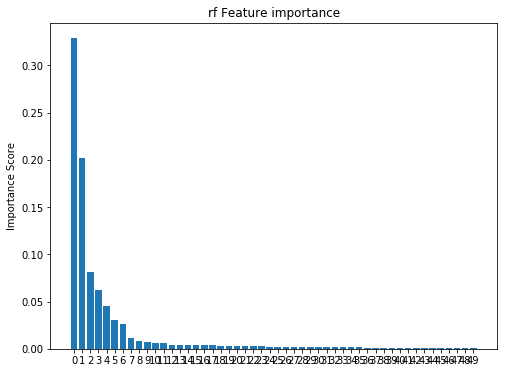

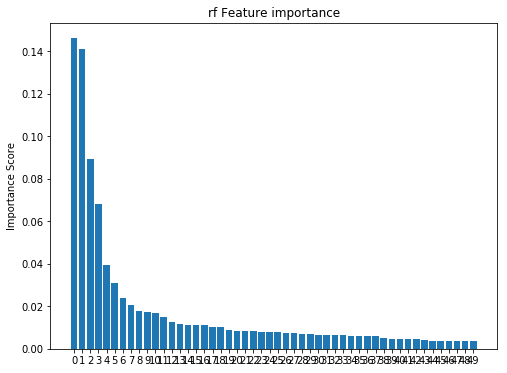

In [220]:
rf_res10 = pd.DataFrame(feat_sel(df10, output, features10 , feat_num=50))
rf_res85 = pd.DataFrame(feat_sel(df85, output, features85, feat_num=50))


LASSO Feature Selection

/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


lasso Feature ranking:        0                                                  1
0  0.495  Estimate__SELECTED_MONTHLY_OWNER_COSTS_SMOC__M...
1  0.275                  Percent__GROSS_RENT__1500_or_more
2  0.245  Estimate__SELECTED_MONTHLY_OWNER_COSTS_SMOC__M...
3  0.180  Percent__SELECTED_MONTHLY_OWNER_COSTS_SMOC__20...
4  0.085               Estimate__GROSS_RENT__Median_dollars


/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


lasso Feature ranking:        0                                         1
0  0.540  County_PriceToRentRatio_AllHomes_current
1  0.535          Adjusted_gross_income_per_return
2  0.530                                     19300
3  0.525     Dividends_before_exclusion_per_return
4  0.460                                     04800


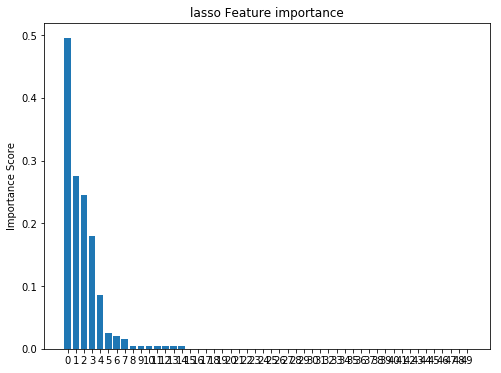

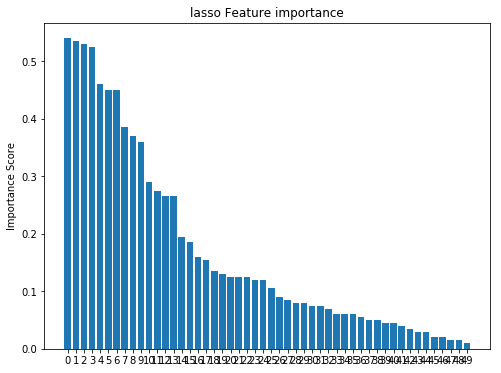

In [221]:
lasso_res10 = pd.DataFrame(feat_sel(df10, output, features10, model='lasso',
                                    alpha = 1000, feat_num=50))
lasso_res85 = pd.DataFrame(feat_sel(df85, output, features85 , model='lasso',
                                    alpha = 100, feat_num=50))

Comparing the Feature Importance from the Two selection methods

In [222]:
res10 = pd.merge(lasso_res10, rf_res10,on=1, how='outer', suffixes=('_las', '_rf'))

In [223]:
res85 = pd.merge(lasso_res85, rf_res85, on=1, how='outer', suffixes=('_las', '_rf'))

In [224]:
res85['avg_score'] = res85.mean(axis=1)
res10['avg_score'] = res10.mean(axis=1)

In [225]:
res10 = res10.sort_values(by='avg_score', ascending=False)
res85 = res85.sort_values(by='avg_score', ascending=False)

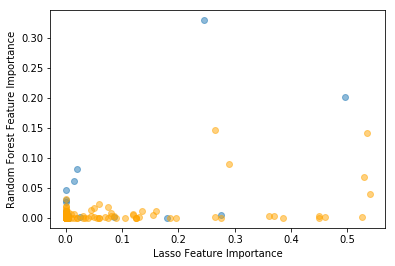

In [226]:
#feats = pd.merge(lasso_res, rf_res, on=1, suffixes=('_lasso', '_rf'))
pl.plot(res10['0_las'], res10['0_rf'], 'o', alpha=.5)
pl.plot(res85['0_las'], res85['0_rf'], 'o', alpha=.5, c='orange')
pl.xlabel('Lasso Feature Importance')
pl.ylabel('Random Forest Feature Importance')

In [227]:
res85['labels'] = res85[1].str.slice(0, 30)

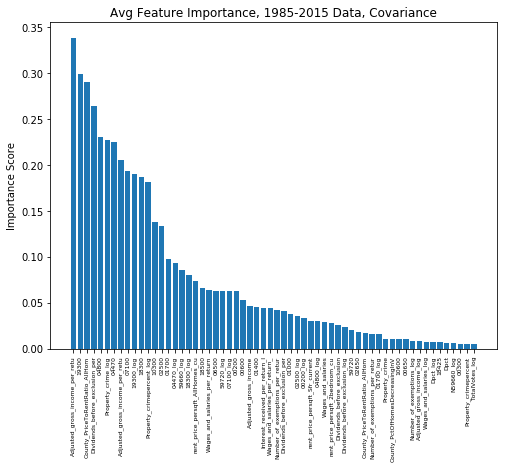

In [237]:
pl.figure(figsize=(8,6))
pl.title("Avg Feature Importance, 1985-2015 Data, Covariance")
pl.bar(np.arange(60), res85['avg_score'][:60], align='center')
pl.xticks(np.arange(60), res85['labels'][:60], rotation=90, fontsize=6)
pl.ylabel('Importance Score')

In [229]:
feats85 = res85[1][:60]

In [230]:
res10['labels'] = res10[1].str.slice(0, 30)

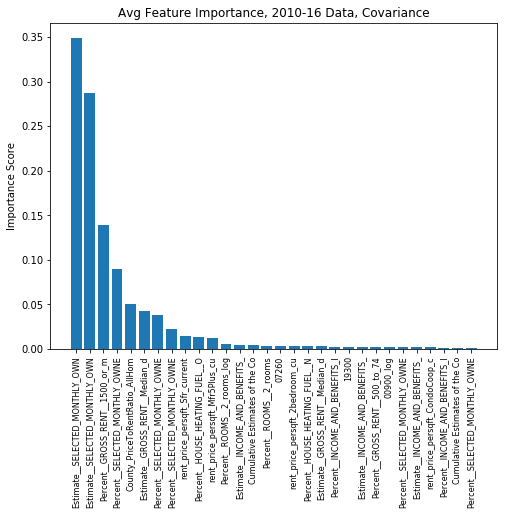

In [231]:
pl.figure(figsize=(8,6))
pl.title("Avg Feature Importance, 2010-16 Data, Covariance")
pl.bar(np.arange(30), res10['avg_score'][:30], align='center')
pl.xticks(np.arange(30), res10['labels'][:30], rotation=90, fontsize=8)
pl.ylabel('Importance Score')

In [232]:
feats10 = res10[1][:30]

In [233]:
l = []
for i in feats85:
    if '_log' in i:
        l.append(i)
        
m = [x.strip('_log')for x in l]
p = [x for x in m if (feats85 == x).sum() > 0]
q = [x + ('_log')for x in p]
feats85 = list(feats85)
[feats85.remove(x) for x in q]
feats85

['Adjusted_gross_income_per_return',
 '19300',
 'County_PriceToRentRatio_AllHomes_current',
 'Dividends_before_exclusion_per_return',
 '04800',
 '04470',
 '07100',
 '18300',
 '10300',
 '02500',
 '01700',
 '59660_log',
 'rent_price_persqft_AllHomes_current',
 '18500',
 'Wages_and_salaries_per_return',
 '06500',
 '00200',
 '00600',
 'Adjusted_gross_income',
 '01400',
 'Interest_received_per_return_log',
 '01000',
 'rent_price_persqft_Sfr_current',
 'Wages_and_salaries',
 'rent_price_persqft_2bedroom_current',
 'Dividends_before_exclusion',
 '59720',
 '02650',
 'County_PriceToRentRatio_AllHomes',
 'Number_of_exemptions_per_return',
 'Property_crime',
 'County_PctOfHomesDecreasingInValues_AllHomes_current',
 '10600',
 '00650',
 'Number_of_exemptions_log',
 '18425',
 'Dpct',
 'N59660_log',
 '00300',
 'Property_crimepercent',
 'TotalVotes_log']

In [234]:
l = []
for i in feats10:
    if '_log' in i:
        l.append(i)
        
m = [x.strip('_log')for x in l]
p = [x for x in m if (feats10 == x).sum() > 0]
q = [x + ('_log')for x in p]
feats10 = list(feats10)
[feats10.remove(x) for x in q]
feats10

['Estimate__SELECTED_MONTHLY_OWNER_COSTS_SMOC__Median_dollars',
 'Percent__GROSS_RENT__1500_or_more',
 'Percent__SELECTED_MONTHLY_OWNER_COSTS_SMOC__2000_or_more',
 'County_PriceToRentRatio_AllHomes_current',
 'Estimate__GROSS_RENT__Median_dollars',
 'Percent__SELECTED_MONTHLY_OWNER_COSTS_SMOC__700_to_999_log',
 'rent_price_persqft_Sfr_current',
 'Percent__HOUSE_HEATING_FUEL__Occupied_housing_units__No_fuel_used',
 'rent_price_persqft_Mfr5Plus_current',
 'Estimate__INCOME_AND_BENEFITS_IN__INFLATIONADJUSTED_DOLLARS__Mean_household_income_dollars',
 'Cumulative Estimates of the Components of Population Change - April 1,  to July 1,  - Total Population Change [1]percent',
 'Percent__ROOMS__2_rooms',
 '07260',
 'rent_price_persqft_2bedroom_current',
 'Percent__HOUSE_HEATING_FUEL__No_fuel_used',
 'Percent__INCOME_AND_BENEFITS_IN__INFLATIONADJUSTED_DOLLARS__200000_or_more',
 '19300',
 'Estimate__INCOME_AND_BENEFITS_IN__INFLATIONADJUSTED_DOLLARS__Nonfamily_households__Mean_nonfamily_income_dol

In [235]:
output = 'ZHVI_AllHomes_current'

In [238]:
covar_85 = df85[feats85 + [output, 'FIPS', 'STATE', 'YEAR']]

In [239]:
covar_85.to_csv('./data/dataframes/covar85.csv')

In [240]:
covar_10 = df10[feats10 + [output, 'FIPS', 'STATE', 'YEAR']]
covar_10.to_csv('./data/dataframes/covar10.csv')

### Alpha Feature Selection

In [186]:
output = 'ZHVI_AllHomes_next'

Drop rows where there is no value for the output variable.

In [187]:
print ('cols: ', len(ddf10.columns), 'rows: ', len(ddf10))
df10 = ddf10.dropna(how='any', subset=[output])
#Check row and column length
print ('cols: ', len(df10.columns), 'rows: ', len(df10))

print ('cols: ', len(ddf85.columns), 'rows: ', len(ddf85))
df85 = ddf85.dropna(how='any', subset=[output])
#Check row and column length
print ('cols: ', len(df85.columns), 'rows: ', len(df85))

cols:  2846 rows:  3377
cols:  2846 rows:  3344
cols:  484 rows:  12056
cols:  484 rows:  10714


Drop features that are too closely associated with home value

In [188]:
zillow_feats = [word+'_next' for word in home_value_indicators] + [word+'_current' for word in home_value_indicators]
#Drop home value indicators
zillow_feats.remove(output)
zillow_feats.remove('Med_Listing_Price_AllHomes_current')
zillow_feats.remove('Med_Listing_Price_AllHomes_next')
zillow_feats.remove('Med_Listing_Price_Sfr_next')
zillow_feats.remove('Med_Listing_Price_Sfr_current')

df10.drop(zillow_feats, axis=1, inplace=True)
df85.drop(zillow_feats, axis=1, inplace=True)

/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


Remove other Next period values from

In [189]:
next_list = column_filter(df85, '_next')
next_list.remove(output)
df85.drop(next_list, axis=1, inplace=True)
next_list = column_filter(df10, '_next')
next_list.remove(output)
df10.drop(next_list, axis=1, inplace=True)

Columns matching filter: 17
Columns matching filter: 17


/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Random Forest

In [190]:
df85.replace(to_replace=[-np.inf, np.inf], value=[1, 1], inplace=True)
df10.replace(to_replace=[-np.inf, np.inf], value=[1, 1], inplace=True)

/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [191]:
df85['RelDif_ZHVI'].fillna(df85['RelDif_ZHVI'].mean(), inplace=True)
df10['RelDif_ZHVI'].fillna(df10['RelDif_ZHVI'].mean(), inplace=True)
df85['Rel_ZHVI'].fillna(df85['Rel_ZHVI'].mean(), inplace=True)
df10['Rel_ZHVI'].fillna(df10['Rel_ZHVI'].mean(), inplace=True)

/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [192]:
df85.drop(['Rel_ZHVI'], axis=1, inplace=True)
df85.drop(['RelDif_ZHVI'], axis=1, inplace=True)#
df10.drop(['RelDif_ZHVI'], axis=1, inplace=True)
df10.drop(['Rel_ZHVI'], axis=1, inplace=True)

/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so w

In [193]:
features10 = list(set(df10.columns) - set(['FIPS', 'COUNTYNAME', 'YEAR', 'YEAR_log', output] + zillow_feats))
features85 = list(set(df85.columns) - set(['FIPS', 'COUNTYNAME', 'YEAR', 'YEAR_log', output] + zillow_feats))

/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


R-Score 0.980988942733
rf Feature ranking:         0                                                  1
0  0.2929  Estimate__SELECTED_MONTHLY_OWNER_COSTS_SMOC__M...
1  0.0945  Estimate__SELECTED_MONTHLY_OWNER_COSTS_SMOC__M...
2  0.0944  Percent__SELECTED_MONTHLY_OWNER_COSTS_SMOC__20...
3  0.0584               Estimate__GROSS_RENT__Median_dollars
4  0.0562           County_PriceToRentRatio_AllHomes_current


/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


R-Score 0.974877408842
rf Feature ranking:         0                                                  1
0  0.1667                   Adjusted_gross_income_per_return
1  0.1193               Adjusted_gross_income_per_return_log
2  0.0529                                          00200_log
3  0.0429  County_PctOfHomesDecreasingInValues_AllHomes_c...
4  0.0424                                          19300_log


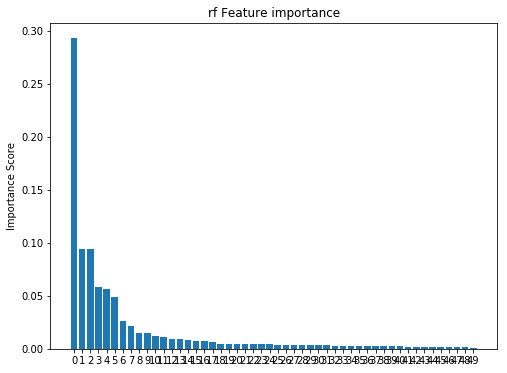

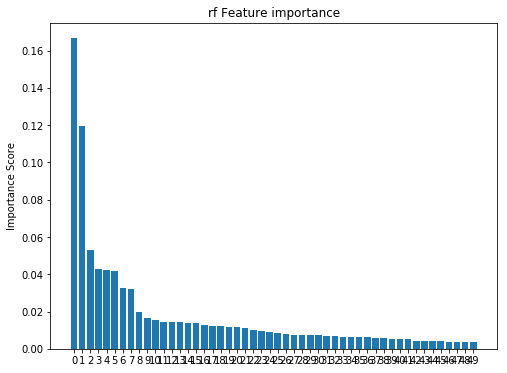

In [194]:
rf_res10 = pd.DataFrame(feat_sel(df10, output, features10 , feat_num=50))
rf_res85 = pd.DataFrame(feat_sel(df85, output, features85, feat_num=50))


LASSO Feature Selection

/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


lasso Feature ranking:        0                                                  1
0  0.505  Estimate__SELECTED_MONTHLY_OWNER_COSTS_SMOC__M...
1  0.430                  Percent__GROSS_RENT__1500_or_more
2  0.270  Estimate__SELECTED_MONTHLY_OWNER_COSTS_SMOC__M...
3  0.195  Percent__SELECTED_MONTHLY_OWNER_COSTS_SMOC__20...
4  0.160               Estimate__GROSS_RENT__Median_dollars


/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


lasso Feature ranking:        0                                         1
0  0.585          Adjusted_gross_income_per_return
1  0.540  County_PriceToRentRatio_AllHomes_current
2  0.520                                     19300
3  0.510                                     07100
4  0.485                                     04800


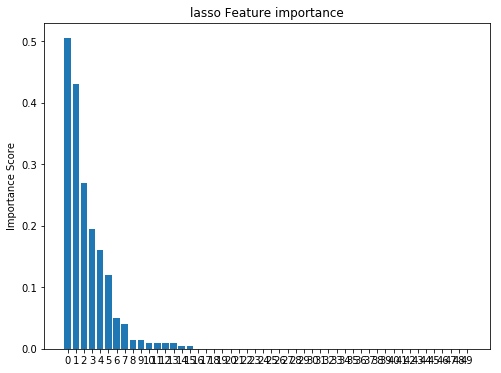

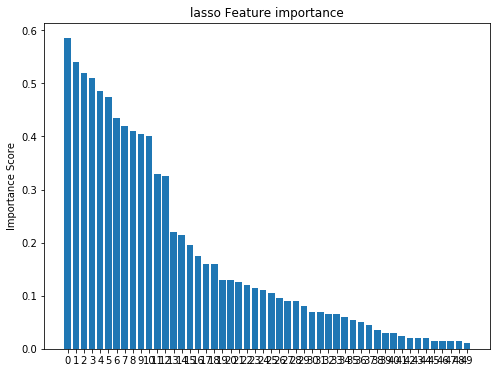

In [195]:
lasso_res10 = pd.DataFrame(feat_sel(df10, output, features10, model='lasso',
                                    alpha = 1000, feat_num=50))
lasso_res85 = pd.DataFrame(feat_sel(df85, output, features85 , model='lasso',
                                    alpha = 100, feat_num=50))

Comparing the Feature Importance from the Two selection methods

In [196]:
res10 = pd.merge(lasso_res10, rf_res10,on=1, how='outer', suffixes=('_las', '_rf'))

In [197]:
res85 = pd.merge(lasso_res85, rf_res85, on=1, how='outer', suffixes=('_las', '_rf'))

In [198]:
res85['avg_score'] = res85.mean(axis=1)
res10['avg_score'] = res10.mean(axis=1)

In [199]:
res10 = res10.sort_values(by='avg_score', ascending=False)
res85 = res85.sort_values(by='avg_score', ascending=False)

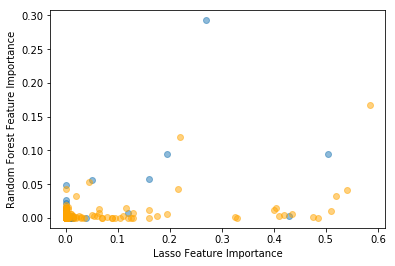

In [200]:
#feats = pd.merge(lasso_res, rf_res, on=1, suffixes=('_lasso', '_rf'))
pl.plot(res10['0_las'], res10['0_rf'], 'o', alpha=.5)
pl.plot(res85['0_las'], res85['0_rf'], 'o', alpha=.5, c='orange')
pl.xlabel('Lasso Feature Importance')
pl.ylabel('Random Forest Feature Importance')

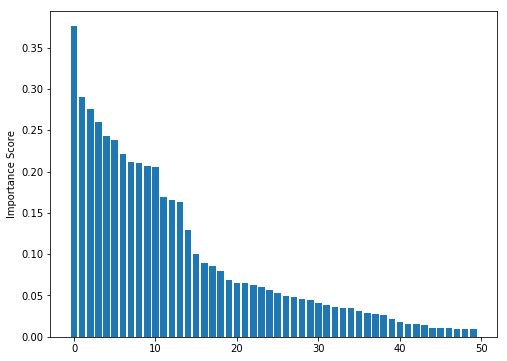

In [201]:
pl.figure(figsize=(8,6))
#pl.title("{} Feature importance".format(model))
pl.bar(np.arange(50), res85['avg_score'][:50], align='center')
#pl.xticks(np.arange(feat_num))
pl.ylabel('Importance Score')

In [202]:
feats85 = res85[1][:50]

In [203]:
res10['labels'] = res10[1].str.slice(0, 30)

In [204]:
res85['labels'] = res85[1].str.slice(0, 30)

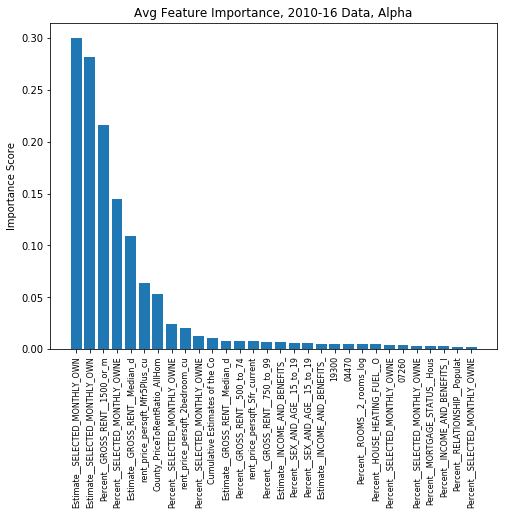

In [205]:
pl.figure(figsize=(8,6))
pl.title("Avg Feature Importance, 2010-16 Data, Alpha")
pl.bar(np.arange(30), res10['avg_score'][:30], align='center')
pl.xticks(np.arange(30), res10['labels'][:30], rotation=90, fontsize=8)
pl.ylabel('Importance Score')

In [206]:
feats10 = res10[1][:30]

In [207]:
l = []
for i in feats85:
    if '_log' in i:
        l.append(i)
        
m = [x.strip('_log')for x in l]
p = [x for x in m if (feats85 == x).sum() > 0]
q = [x + ('_log')for x in p]
feats85 = list(feats85)
[feats85.remove(x) for x in q]
feats85

['Adjusted_gross_income_per_return',
 'County_PriceToRentRatio_AllHomes_current',
 '19300',
 '07100',
 '04800',
 '04470',
 'Property_crimepercent_log',
 'Property_crime_log',
 '02500',
 'Dividends_before_exclusion_per_return',
 '18300',
 '10300',
 '01700',
 'rent_price_persqft_AllHomes_current',
 'Adjusted_gross_income',
 'Wages_and_salaries_per_return',
 '00200',
 '02650',
 '06500',
 '00600',
 '59720_log',
 'rent_price_persqft_Sfr_current',
 '01400',
 'rent_price_persqft_2bedroom_current',
 'Interest_received_per_return_log',
 'Wages_and_salaries',
 'County_PctOfHomesDecreasingInValues_AllHomes_current',
 '01000',
 '18500',
 '10600',
 'Dividends_before_exclusion',
 '59660',
 '00650',
 'Number_of_exemptions_log',
 'Number_of_exemptions_per_return']

In [208]:
l = []
for i in feats10:
    if '_log' in i:
        l.append(i)
        
m = [x.strip('_log')for x in l]
p = [x for x in m if (feats10 == x).sum() > 0]
q = [x + ('_log')for x in p]
feats10 = list(feats10)
[feats10.remove(x) for x in q]
feats10

['Estimate__SELECTED_MONTHLY_OWNER_COSTS_SMOC__Median_dollars',
 'Percent__GROSS_RENT__1500_or_more',
 'Percent__SELECTED_MONTHLY_OWNER_COSTS_SMOC__2000_or_more',
 'Estimate__GROSS_RENT__Median_dollars',
 'rent_price_persqft_Mfr5Plus_current',
 'County_PriceToRentRatio_AllHomes_current',
 'rent_price_persqft_2bedroom_current',
 'Percent__SELECTED_MONTHLY_OWNER_COSTS_SMOC__1000_to_1499',
 'Cumulative Estimates of the Components of Population Change - April 1,  to July 1,  - Total Population Change [1]percent',
 'Percent__GROSS_RENT__500_to_749_log',
 'rent_price_persqft_Sfr_current',
 'Percent__GROSS_RENT__750_to_999',
 'Estimate__INCOME_AND_BENEFITS_IN__INFLATIONADJUSTED_DOLLARS__Mean_household_income_dollars',
 'Percent__SEX_AND_AGE__15_to_19_years',
 'Estimate__INCOME_AND_BENEFITS_IN__INFLATIONADJUSTED_DOLLARS__Nonfamily_households__Mean_nonfamily_income_dollars',
 '19300',
 '04470',
 'Percent__ROOMS__2_rooms_log',
 'Percent__HOUSE_HEATING_FUEL__Occupied_housing_units__No_fuel_used',

In [209]:
alpha_85 = df85[feats85 + [output, 'FIPS', 'STATE', 'YEAR']]

In [210]:
alpha_85.to_csv('./data/dataframes/alpha85.csv')

In [211]:
alpha_10 = df10[feats10 + [output, 'FIPS', 'STATE', 'YEAR']]
alpha_10.to_csv('./data/dataframes/alpha10.csv')